O problema que estamos tentanto resolver nessa sessão do projeto é o de entender o nível de indelicadeza das respostas na plataforma do StackOverflow.

A nossa suposição inicial baseada na experiência e uso da plataforma é que a maioria das respostas são educadas e respeitosas, mas que existe uma minoria que não segue essas regras.

Para entender melhor esse problema, iremos analisar as respostas com um classificador de sentimentos e classificá-las em positivas, negativas ou neutra. A biblioteca escolhida para isso é a transformers, utilizando o modelo cardiffnlp/twitter-xlm-roberta-base-sentiment, que foi treinado com cerca de 200 milhões de tweets.

## Importação e pré-processamento do dataset

In [2]:
import pandas as pd

# Lê dataset de respostas
answers_df = pd.read_csv('data/Answers_sample.csv', encoding="ISO-8859-1", usecols = ['Id', 'Score', 'Body'])

# Caso o arquivo Answers_sample.csv não exista ainda, descomente a linha abaixo
# answers_df = pd.read_csv('data/Answers.csv', encoding="ISO-8859-1", usecols = ['Id', 'Score', 'Body'])
# answers_df_sample = answers_df.sample(20000)
# answers_df_sample.to_csv('data/Answers_sample.csv', index=False)

In [3]:
# Prepara dataset de respostas, removendo tags html e quebras de linha
answers_df['Body'] = answers_df['Body'].str.replace('<pre>.*?</pre>', '', regex=True)
answers_df['Body'] = answers_df['Body'].str.replace('<code>.*?</code>', '', regex=True)
answers_df['Body'] = answers_df['Body'].str.replace('<[^>]+>', '', regex=True)
answers_df['Body'] = answers_df['Body'].str.replace('\n+', '. ', regex=True)
answers_df

,Id,Score,Body
0,12917285,1,Quick way to force a rebind. dataGridView.Data...
1,39657792,0,Another option is to transpose your output wc_...
2,15082200,1,The only way to do this was to edit the header...
3,4092346,8,"If you have to hand code one, recursive descen..."
4,26484032,1,Updated Answer. If you want to get all files f...
...,...,...,...
19995,33542310,0,First of all attribute should be unique on a ...
19996,8937321,2,"I think you need to show content in tag,. the..."
19997,21499491,0,So you want to remove all the non-digits from ...
19998,30738604,0,To export model data to PDF you will have to u...


# Aplicação do modelo de classificação de sentimentos

In [11]:
from transformers import pipeline

# Importa e inicializa o modelo de análise de sentimento
model_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
classifier = pipeline(task="sentiment-analysis", model=model_path, tokenizer=model_path)

O seguinte código para classificação de sentimento demora cerca de 9 horas para ser executado, portanto, ao invés de executá-lo a tomo momento, na célula posterior, utilizamos o arquivo "results/processed_answers.csv" para carregar os resultados já processados.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Aplica a função de classificação de sentimento
def classify_sentiment(body):
    sentiment = classifier(body)[0]
    return [sentiment['label'], sentiment['score']]

# Cria um executor de threads e uma lista de futuros
executor = ThreadPoolExecutor()

# Popula uma lista de futuros com os resultados da classificação de sentimento
futures = []
for body in answers_df['Body']:
    future = executor.submit(classify_sentiment, body)
    futures.append(future)

# Executa as threads da lista de futuros e armazena os resultados
results = []
for index, future in enumerate(as_completed(futures)):
    try:
        result = future.result()
        row = answers_df.iloc[index]
        results.append([row.Id, row.Score, row.Body, result[0], result[1]])
        print(f"Completed {index+1} - {result}")

    except Exception as e:
        results.append([])
        print(f"Error: {e}")

# Salva os resultados em um arquivo csv
processed = pd.DataFrame(results, columns=['Id', 'Score', 'Body', 'Sentiment_Label', 'Sentiment_Score'])
processed.to_csv('results/processed_answers.csv', index=False)

Aqui vale resaltar que devido a algum problema da execução em paralelo de classificação, que não conseguimos resolver a tempo, algumas classificações não foram realizadas, portanto, o arquivo "results/processed_answers.csv" contém apenas 18752 respostas classificadas (ao invés de 20000), e devemos filtrá-las.

In [5]:
# Lê o arquivo csv com os resultados da classificação de sentimento e adiciona ao dataset de respostas
answers_df_classified = pd.read_csv('results/processed_answers.csv', encoding="ISO-8859-1", usecols = ['Id', 'Score', 'Body', 'Sentiment_Label', 'Sentiment_Score'])

# Filtra as respostas que não foram classificadas
answers_df_classified = answers_df_classified[answers_df_classified['Sentiment_Label'].notna()]
answers_df_classified

,Id,Score,Body,Sentiment_Label,Sentiment_Score
2,15082200,1,The only way to do this was to edit the header...,neutral,0.824382
4,26484032,1,Updated Answer. If you want to get all files f...,neutral,0.826687
6,30668892,0,Your is not a MySQLi connection link. Check i...,neutral,0.830514
7,28751626,2,EDIT 2 - Revised answer based on comments:. Fr...,neutral,0.526152
8,22843514,3,Usually we do something like this:. #if define...,neutral,0.788638
...,...,...,...,...,...
19995,33542310,0,First of all attribute should be unique on a ...,neutral,0.634899
19996,8937321,2,"I think you need to show content in tag,. the...",neutral,0.604542
19997,21499491,0,So you want to remove all the non-digits from ...,neutral,0.473182
19998,30738604,0,To export model data to PDF you will have to u...,neutral,0.704524


# Análise dos Resultados

## Histograma das classificações
Iniciamos nossa análise explorando a distribuição das classificações para entender melhor o contexto do problema. Foi observado que a maioria das respostas é classificada como neutra, o que é apropriado para o propósito da plataforma, que é fornecer uma comunidade para discussões técnicas e objetivas, sem a necessidade de julgamentos de valor.

<Axes: title={'center': 'Sentiment_Label'}, xlabel='label', ylabel='Count'>

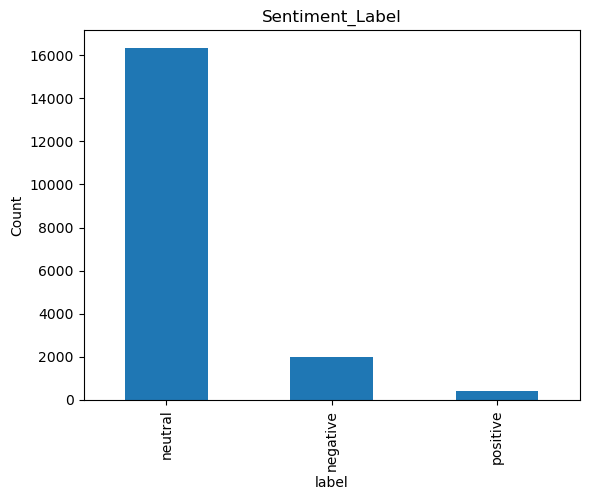

In [6]:
# Gera um gráfico de barras com a quantidade de respostas por sentimento
answers_df_classified.value_counts('Sentiment_Label').plot(kind='bar', title='Sentiment_Label', ylabel='Count', xlabel='label')

## Análise dado a dado
A seguir vamos analisar algum exemplos de comentários classficados como neutro, negativos e positivos

In [35]:
# Filtra apenas as respostas com sentimento negativo
negative_answers_df = answers_df_classified[answers_df_classified['Sentiment_Label'] == 'negative']
negative_answers_df = negative_answers_df.sort_values(by=['Sentiment_Score'], ascending=False)

# Filtra apenas as respostas com sentimento positivo
positive_answers_df = answers_df_classified[answers_df_classified['Sentiment_Label'] == 'positive']
positive_answers_df = positive_answers_df.sort_values(by=['Sentiment_Score'], ascending=False)

# Filtra apenas as respostas com sentimento neutro
neutral_answers_df = answers_df_classified[answers_df_classified['Sentiment_Label'] == 'neutral']
neutral_answers_df = neutral_answers_df.sort_values(by=['Sentiment_Score'], ascending=False)

In [29]:
def print_text(text, max_line_length, start_text = ""):
    lines = []
    words = text.split()
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_line_length:
            current_line += " " + word
        else:
            lines.append(current_line.strip())
            current_line = word
    if current_line:
        lines.append(current_line.strip())
    print(f"\n{start_text}".join(lines))

In [36]:
# Imprime o Body das 3 primeiras respostas mais neutras
for index, row in neutral_answers_df.head(3).iterrows():
    print(f"Sentiment_Label: {row.Sentiment_Label}, Sentiment_Score: {row.Sentiment_Score}")
    print_text(f"Body: {row.Body}", 100, "  ")
    print()

Sentiment_Label: neutral, Sentiment_Score: 0.9152563214302064
Body: Basically, you have a tightly coupled bowl of spaghetti which in it's current state, probably
  can't be untangled.. The main problem you have is the fact that you are creating new instance of , ,
  and all over the place. This means that from one part of your application to the next, they are all
  using their own instance of these classes, which don't relate to each other.. The other problem is
  that many of these parts of the application actually shouldn't need direct access to the objects
  that you are try to access.. Instead, start by breaking down you application into usable
  components/elements, with defined responsibilities.. For example, the UI parts should gather
  information which is feed back into the system for processing. The processing layer shouldn't care
  where this information came from, only that it conforms to it's needs.. For example.... The
  following simply generates a login dialog which wi

In [30]:
# Imprime o Body das 3 primeiras respostas mais negativas
for index, row in negative_answers_df.head(3).iterrows():
    print(f"Sentiment_Label: {row.Sentiment_Label}, Sentiment_Score: {row.Sentiment_Score}")
    print_text(f"Body: {row.Body}", 100, "  ")
    print()

Sentiment_Label: negative, Sentiment_Score: 0.946388840675354
Body: . why does the standard provide a constructor that takes a T* on shared_ptr if it's so unsafe
  to do?. Because it's the only way to have s without being intrusive. You can use a on anything. I've
  even used them on objects from C interfaces, via the use of a destructor. Things like a and so
  forth. That way, I never have to free anything ever again.. You can't do that with ; it only works
  for -style objects.. Also, there is , which creates a directly from an object types and the argument
  to the constructor. So you never even see the pointer (and it usually allocates the object and its
  ref-count in one allocation instead of two).. The proper C++ idiom with is very simple: always use
  or . If you can't use them, then the proper idiom is to only use the direct naked pointer
  constructor in tandem with : Never use it on pointers that you don't know the origin of.. Is there
  an alternative with shared/weak_ptr?.

In [32]:
# Imprime o Body de 3 respostas positivas (não foram impressas as primerias 3 porque eram muitos grandes para caber em um print)
for index, row in positive_answers_df[3:6].iterrows():
    print(f"Sentiment_Label: {row.Sentiment_Label}, Sentiment_Score: {row.Sentiment_Score}")
    print_text(f"Body: {row.Body}", 100, "  ")
    print()

Sentiment_Label: positive, Sentiment_Score: 0.8874438405036926
Body: I have quite a large .NET &lt;-> COM bookmark collection that I'm dumping below. . The
  problem is that no one tutorial/article covers all the basics and gotacha's. So you need to go
  through a couple of them and mix and match, depending on what you want to do.. Here's the best of
  what I've found so far.... General .NET COM Articles/Tutorials . .NET - COM Interoperability. . COM
  Interoperability in .NET Framework: Part I. . Understanding Classic COM Interoperability With .NET
  Applications. . Exposing .NET Components to COM. . Building COM Objects in C#. . Calling Managed
  .NET C# COM Objects from Unmanaged C++ Code. . Native &amp; Managed Interop Made Simple. . Using
  .NET Assembly with COM Client. . Moserware: Using Obscure Windows COM APIs in .NET . COM
  Interoperability in .NET Part 1 Part 2. Part 3 . COM Interop Part 1: C# Client Tutorial. Part 2: C#
  Server Tutorial . Calling a COM Component From C# (

Podemos ver que as classificações positivas e negativas apesar de acusarem um score alto de chance de acerto, não apresentam uma classificação adequada, se assemelham muito mais ao que consideraríamos de neutro. Já as neutras aparentam ter uma classificação adequada.

## Resultado

Com base apenas na análise de sentimentos utilizando o modelo cardiffnlp/twitter-xlm-roberta-base-sentiment, podemos concluir que a maioria das respostas são neutras, e as classificações positivas e negativas aparentam ser falsos positivos, ou seja, não são classificações adequadas. Portanto, com os dados obtidos, podemos chegar a possíveis 3 conclusões (e não excludentes entre si):
- Não existe um problema de indelicadeza nas respostas do StackOverflow (e ou a moderação é eficiente);
- O modelo utilizado não é adequado para a classificação de sentimentos em respostas deste tipo;
- Talvez alguma parametrização do modelo ou do dataset de treinamento possa melhorar a classificação.